In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, KBinsDiscretizer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor

ohe = OneHotEncoder(sparse=False, drop='first')

In [2]:
train = pd.read_csv('DateTimePandas/bike_train.csv')

In [ ]:
train.sample(5)

In [ ]:
train.head()

In [ ]:
train.info()

In [3]:
train['datetime'] = pd.to_datetime(train['datetime'])


In [4]:
train['datehour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.dayofweek
train['month'] = train['datetime'].dt.month
train['year'] = train['datetime'].dt.year
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datehour,weekday,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,2011


In [ ]:
train['workingday'].unique()

In [ ]:
train['workingday'].value_counts()

In [ ]:
#sns.heatmap(train.corr(),annot=True)

In [5]:
X = train.drop(['season','casual','registered','count','atemp','datetime','weather'],axis=1)

y_1 = train['casual']
y_2 = train['registered']

In [6]:
X_train, X_test, y_train_casual, y_test_casual, y_train_registered, y_test_registered = train_test_split(X , y_1 , y_2 , test_size=0.25,random_state=6)

In [7]:
def rmsle(y, ypred):
    ypred[ypred<0]=0
    return metrics.mean_squared_log_error(y, ypred)**0.5

In [8]:
rmsle_loss = metrics.make_scorer(rmsle, greater_is_better=True)

In [9]:
poly_and_scale = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False,interaction_only=True),
    MinMaxScaler()
)

In [10]:
categorical = ['datehour','weekday','month','year']
numerical = ['temp','humidity','windspeed']
ready = ['holiday','workingday']

feature_eng = ColumnTransformer([
    ('one-hot', OneHotEncoder(), categorical),
    # applies polynomial features only to the two columns
    # interaction effect between number of rooms and size of your appartment
    ('scaling', poly_and_scale, numerical),
    ('do-nothing', 'passthrough', ready)
])


In [11]:
modelgrid = make_pipeline(
    feature_eng,
    RandomForestRegressor()
)

In [12]:
modelgrid.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('one-hot', OneHotEncoder(),
                                    ['datehour', 'weekday', 'month', 'year']),
                                   ('scaling',
                                    Pipeline(steps=[('polynomialfeatures',
                                                     PolynomialFeatures(include_bias=False,
                                                                        interaction_only=True)),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    ['temp', 'humidity', 'windspeed']),
                                   ('do-nothing', 'passthrough',
                                    ['holiday', 'workingday'])])),
  ('randomforestregressor', RandomForestRegressor())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('one-hot', OneHotEncod

In [13]:
# define which hyperparameters we want to search and the values that should be used

para_grid = {
            'columntransformer__scaling__polynomialfeatures__degree': [1,2,3,4]
            ,'columntransformer__scaling__polynomialfeatures__interaction_only': [True, False]
            }

In [14]:
# define your gridsearch

grid_cv = GridSearchCV(
            estimator= modelgrid, # the model!
            param_grid= para_grid, # hyperparameters to compare
            cv=5, # folds
            return_train_score=True,
            scoring= rmsle_loss,
            n_jobs=-1, # how many cores to use on your computer, -1 uses all
)

In [15]:
# fit all the models with the different combinations

grid_cv.fit(X_train, y_train_casual)


# these columns are what we find important

col_filter = ['param_columntransformer__scaling__polynomialfeatures__degree', 
              'param_columntransformer__scaling__polynomialfeatures__interaction_only', 
              #'param_ridge__alpha',
              'mean_train_score','mean_test_score', 'rank_test_score']

# put the results into a dataframe

grid_cv_results = pd.DataFrame(grid_cv.cv_results_)

In [16]:
grid_cv.best_params_

{'columntransformer__scaling__polynomialfeatures__degree': 4,
 'columntransformer__scaling__polynomialfeatures__interaction_only': False}

In [17]:
poly_and_scale1 = make_pipeline(
    PolynomialFeatures(degree=4, include_bias=False , interaction_only= False),
    MinMaxScaler()
)
poly_and_scale2 = make_pipeline(
    PolynomialFeatures(degree=4, include_bias=False , interaction_only= False),
    MinMaxScaler()
)

In [18]:
feature_eng1 = ColumnTransformer([
    ('one-hot', OneHotEncoder(), categorical),
    # applies polynomial features only to the two columns
    # interaction effect between number of rooms and size of your appartment
    ('scaling', poly_and_scale, numerical),
    ('do-nothing', 'passthrough', ready)
])

feature_eng2 = ColumnTransformer([
    ('one-hot', OneHotEncoder(), categorical),
    # applies polynomial features only to the two columns
    # interaction effect between number of rooms and size of your appartment
    ('scaling', poly_and_scale, numerical),
    ('do-nothing', 'passthrough', ready)
])

In [19]:
model1 = make_pipeline(
    feature_eng1,
    RandomForestRegressor()
)
model2 = make_pipeline(
    feature_eng2,
    RandomForestRegressor()
)

In [20]:
model1.fit(X_train, y_train_casual)
model2.fit(X_train, y_train_registered)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot', OneHotEncoder(),
                                                  ['datehour', 'weekday',
                                                   'month', 'year']),
                                                 ('scaling',
                                                  Pipeline(steps=[('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed']),
                                                 ('do-nothing', 'pa

In [21]:
casual_predict = model1.predict(X_train)
registered_predict = model2.predict(X_train)

casual_predict[casual_predict < 0] = 0
registered_predict[registered_predict < 0 ] = 0

In [22]:
count_predict = registered_predict + casual_predict
#count_predict[count_predict < 0] = 0
count_predict

array([  6.95, 138.85, 374.94, ...,  17.89,   6.52, 124.86])

In [23]:
casual_predict_test = model1.predict(X_test)
registered_predict_test = model2.predict(X_test)

casual_predict_test[casual_predict_test < 0] = 0
registered_predict_test[registered_predict_test < 0 ] = 0

In [24]:
count_predict_test = registered_predict_test + casual_predict_test
#count_predict_test[count_predict_test < 0] = 0
count_predict_test


array([162.97, 290.88, 228.87, ...,  86.27,  57.52, 386.02])

In [25]:
scores_casual = model1.score(X_train, y_train_casual)
scores_registered = model2.score(X_train, y_train_registered)

print(scores_registered,'<->',scores_casual)
#Score Training Split seperated by registered and casual users

0.9890333221548165 <-> 0.9764250280446235


In [26]:
r2_score(y_train_casual+y_train_registered,count_predict)

0.9888426055281335

In [27]:
rmsle(y_train_casual+y_train_registered,count_predict)  #kaggle score for the combination registered + casual users
# only training split

0.25257501209797656

In [28]:
scores_registered_test = model2.score(X_test, y_test_registered)
scores_casual_test = model1.score(X_test, y_test_casual)
print(scores_registered_test,'<->',scores_casual_test)
#Score Test Split seperated by registered and casual users

0.9108134300275097 <-> 0.8380158921503995


In [29]:
r2_score(y_test_casual+y_test_registered,count_predict_test)

0.9103671361215903

In [30]:
rmsle(y_test_casual+y_test_registered, count_predict_test)  #kaggle score for the combination registered + casual users
# only test split

0.5006662007243272

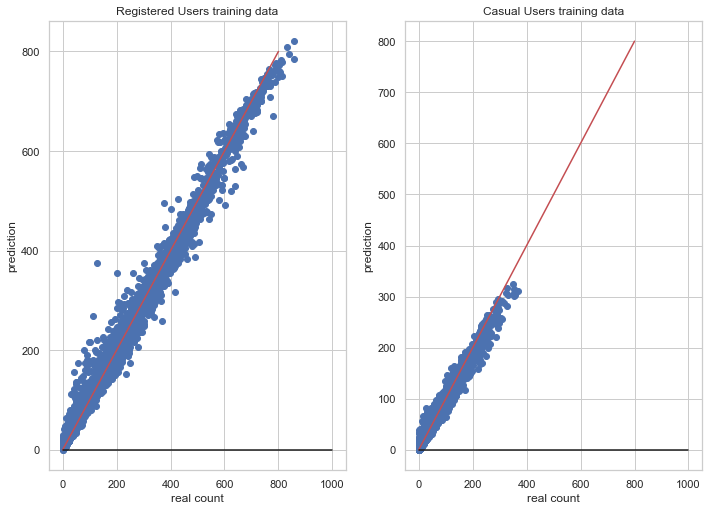

In [31]:
x_l = [0,800]
y_l = [0,800]
x_0 = [0,1000]
y_0 = [0,0]

plt.xlim(left=0,right=1000)

plt.subplot(1,2,1)
plt.title('Registered Users training data')
plt.plot(x_l, y_l, 'r')
plt.plot(x_0, y_0, 'k')
plt.xlabel('real count')
plt.ylabel('prediction')
plt.scatter(y_train_registered, registered_predict)


plt.subplot(1,2,2)
plt.title('Casual Users training data')
plt.plot(x_l, y_l, 'r')
plt.plot(x_0, y_0, 'k')
plt.xlabel('real count')
plt.ylabel('prediction')
plt.scatter(y_train_casual, casual_predict)



Text(0, 0.5, 'prediction')

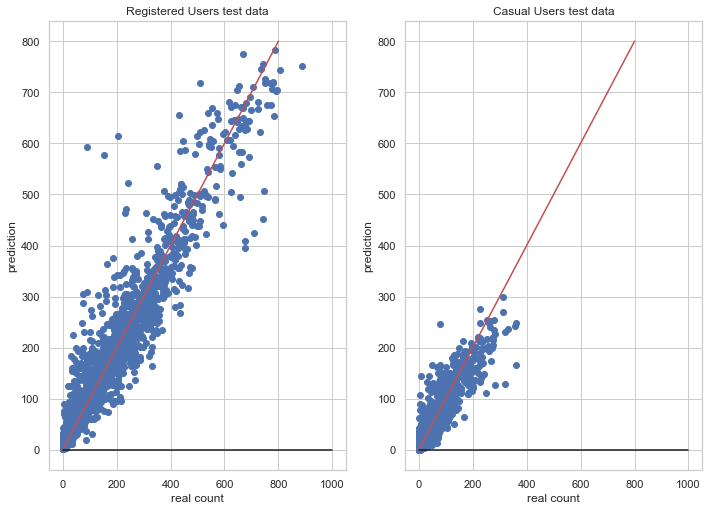

In [32]:
plt.subplot(1,2,1)
plt.title('Registered Users test data')
plt.plot(x_l, y_l, 'r')
plt.plot(x_0, y_0, 'k')
plt.scatter(y_test_registered, registered_predict_test)
plt.xlabel('real count')
plt.ylabel('prediction')

plt.subplot(1,2,2)
plt.title('Casual Users test data')
plt.plot(x_l, y_l, 'r')
plt.plot(x_0, y_0, 'k')
plt.scatter(y_test_casual, casual_predict_test)
plt.xlabel('real count')
plt.ylabel('prediction')


Text(0, 0.5, 'prediction')

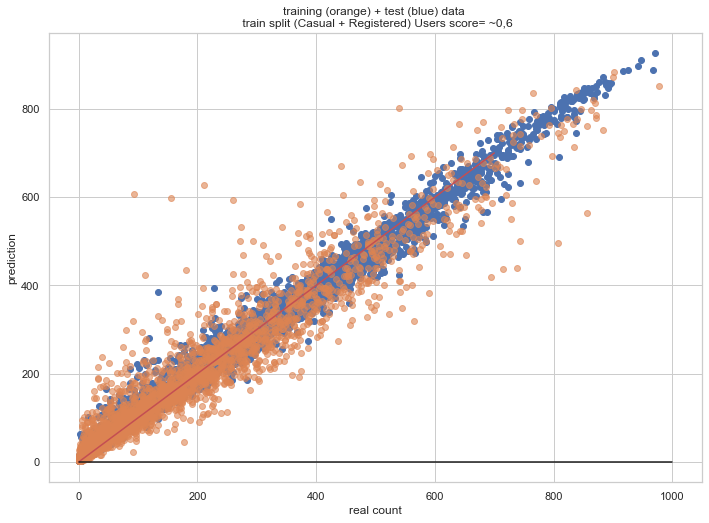

In [33]:
x_l = [0,700]
y_l = [0,700]
x_0 = [0,1000]
y_0 = [0,0]

#plt.xlim(left=0,right=1000)


plt.title('training (orange) + test (blue) data \n train split (Casual + Registered) Users score= ~0,6')
plt.plot(x_l, y_l, 'r')
plt.plot(x_0, y_0, 'k')
plt.scatter(y_train_casual+y_train_registered, count_predict)
plt.scatter(y_test_casual+y_test_registered, count_predict_test,alpha=0.6)
plt.xlabel('real count')
plt.ylabel('prediction')


In [34]:
biketest = pd.read_csv('DateTimePandas/bike_test.csv')

In [35]:
biketest['datetime'] = pd.to_datetime(biketest['datetime'])
biketest['datehour'] = biketest['datetime'].dt.hour
biketest['weekday'] = biketest['datetime'].dt.dayofweek
biketest['month'] = biketest['datetime'].dt.month
biketest['year'] = biketest['datetime'].dt.year
biketest.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datehour,weekday,month,year
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,2011
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,2011
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,2011
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,2011
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,2011


In [36]:
X = biketest.drop(['datetime','season','weather','atemp'],axis=1)

In [37]:
test_casual_predict = model1.predict(X)
test_registered_predict = model2.predict(X)

test_casual_predict[test_casual_predict < 0] = 0
test_registered_predict[test_registered_predict < 0 ] = 0

In [38]:
test_count_predict = test_registered_predict + test_casual_predict
#count_predict[count_predict < 0] = 0
test_count_predict

array([ 21.73,   8.72,   7.09, ..., 130.35, 126.8 ,  64.18])

In [39]:
X.head()

,holiday,workingday,temp,humidity,windspeed,datehour,weekday,month,year
0,0,1,10.66,56,26.0027,0,3,1,2011
1,0,1,10.66,56,0.0000,1,3,1,2011
2,0,1,10.66,56,0.0000,2,3,1,2011
3,0,1,10.66,56,11.0014,3,3,1,2011
4,0,1,10.66,56,11.0014,4,3,1,2011


In [40]:
test_count_predict

array([ 21.73,   8.72,   7.09, ..., 130.35, 126.8 ,  64.18])

In [41]:
tcp_r = np.round(test_count_predict,0)

In [42]:
submit = biketest.drop(['season','weather','atemp'],axis=1)
biketest.head()
#df['newcol'] = pd.Series(your_2d_numpy_array)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datehour,weekday,month,year
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,2011
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,2011
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,2011
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,2011
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,2011


In [43]:
submit['count'] = pd.Series(tcp_r)

In [44]:
submit.drop(['holiday','workingday','temp','humidity','windspeed','datehour','weekday' ,'month','year'],axis=1,inplace = True)
submit.head()

,datetime,count
0,2011-01-20 00:00:00,22.0
1,2011-01-20 01:00:00,9.0
2,2011-01-20 02:00:00,7.0
3,2011-01-20 03:00:00,5.0
4,2011-01-20 04:00:00,3.0


In [70]:
#submit.to_csv('prediction_bike_aoester.csv' , index = False)